# Experiments - Paper Reproduction

The goal of this notebook is reproducing the results from the paper [Building a Sentiment Corpus of Tweets in Brazilian Portuguese](https://arxiv.org/abs/1712.08917).

According to the publication, the steps performed were:
 - Data Representation:
     - Bag-of-words with occurrence of terms.
     - Presence of negation words (“not”, “never”,...) (Avanço et al., 2016).
     - Positive and negative emoticons (Avanço et al., 2016).
     - Positive and negative emojis (Avanço et al., 2016).
     - Presence of positive and negative words (Avanço et al., 2016).
     - PoS tags (NLPnet tagger (Fonseca et al., 2015)).
 - Algorithms:
    - Linear SVM (C: 1).
    - Bernoulli Naive Bayes (alpha:0.1).
    - Logistic Regression.
    - Multilayer Perceptron (2 layers, 200 neurons, learning-rate:00.1).
    - Decision Tree classifier.
    - Random Forest with 200 estimators.

## Libraries and Settings

Thirdy party libraries

In [1]:
# General
import os
import sys
import time
import shutil
import funcy as fp
import numpy as np
import pandas as pd
from functools import partial

# Visualization / Presentation
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML, display

# NLP Libraries e Functions
import re
import nlpnet
import spacy
from spacy.tokenizer import _get_regex_pattern
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, HashingVectorizer

# Model Training and Evaluation
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

# Model Tracking
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

Internal libraries

In [2]:
sys.path.append(os.path.abspath(os.path.pardir))

from src import settings
from src.pipeline.resources import load_corpus, load_stopwords
from src.pipeline.general import clean_text
from src.pipeline.executors import simple_pipeline_executor
from src.pipeline.extractors import (extract_tokens_and_features, extract_features)
from src.pipeline.token_processors import (process_negative_words, process_sentilex_word_polarity, process_token_pos_tag,
                                           process_emoticon_polarity, process_emoji_polarity)
from src.pipeline.sentence_processors import (process_negative_words_features, process_sentilex_polarity_features, process_pos_tag_features,
                                              process_emoticon_polarity_features, process_emoji_polarity_features)
from src.utils import y_hat_to_sparse, y_to_sparse, format_nested_parameters

Presentation settings

In [3]:
%matplotlib inline 
pd.set_option('max_colwidth', 150)

Experiment settings

In [4]:
EXPERIMENT_ID = 1
EXPERIMENT_RUN_NAME = f'01_ReproducePaper'

## Load and Split Dataset

In [5]:
frame = load_corpus()
frame.head()

,id,hashtag,votes,hard,sentiment,group,text,repeat
0,863044774588272640,#encontro,"[1, 1, 1, 1, 1, 1, 1]",0,1,test,que coisa linda O programa estava mostrando uma familia que adotou um adolescente de NUMBER anos que amor !,False
1,865583716088766467,#encontro,"[1, 1, 1, 1, 1, 1, 1]",0,1,test,por mais com as irmãs galvão adorei elas,False
2,865063232201011201,#TheNoite,"[1, 0, 1, 1, 1, 0, 0]",2,1,test,mr CATRA USERNAME lançando sua nova música PPK CHORA no USERNAME k k k 👅 😉 #MrCatra #PpkChora,False
3,864668391008763905,#masterchefbr,"[0, 0, 0, 0, 0, 0, 0]",0,0,test,quem viu aquela lutadora modela barbuda tatuada #MasterChefBR,False
4,865572794016378882,#encontro,"[-1, -1, -1, -1, -1, -1, -1]",0,-1,test,tô passada com esse cara quanta merda pode sair da boca de alguém em alguns minutos 😠,False


Separate training and test records and delete the original frame.

In [6]:
training = frame.loc[(frame.group == 'train') & (frame.sentiment.isin(['-1', '0', '1']))].copy(deep=True)
test = frame.loc[(frame.group == 'test') & (frame.sentiment.isin(['-1', '0', '1']))].copy(deep=True)
del frame

Check class balance on training set

In [7]:
training.sentiment.value_counts()

1     5741
-1    3839
0     3410
Name: sentiment, dtype: int64

## Tokenize and Extract Features from Tweets

Instantiate NLP libraries to tokenize text and extract information (e.g., lemma, pos tag, and polarization).

There two libraries are used:
 - [nlpnet](http://nilc.icmc.usp.br/nlpnet/): Used to be able to reproduce exactly the same pos tags used by TweetSentBR.
 - [Spacy](https://spacy.io/): Lightweight and versatile library to perform tokenization, and get lemma and pos tags.

In [8]:
# Load NLPNet to keep the same pos tagger as the original work
nlpnet.set_data_dir(settings.NLPNET_POS_TAGGER_PATH)
nlpnet_nlp = nlpnet.POSTagger().tag

# Load Spacy to get access tokenization, lemma and pos tag
spacy.prefer_gpu()
spacy_nlp = spacy.load('pt')

# Extend default token regex to avoid splitting hashtag, smile, emoji and emoticon.
re_token_match = _get_regex_pattern(spacy_nlp.Defaults.token_match)
re_token_match = f"({re_token_match}|#\w+|\w+-\w+)"
spacy_nlp.tokenizer.token_match = re.compile(re_token_match).match

Iterate over tweets to trim repeating spaces and words with more than 2 contiguous characters repeated. 

In [9]:
partial_clean_text = partial(clean_text, unify_html_tags=False, unify_urls=False, trim_repeating_spaces=True, unify_hashtags=False,
                             unify_mentions=False, unify_numbers=False, trim_repeating_letters=True)

training.loc[:, 'clean_text'] = training['text'].apply(partial_clean_text)
test.loc[:, 'clean_text'] = test['text'].apply(partial_clean_text)

Check records affected by the cleaning function.

In [10]:
disposable_frame = training.query('text != clean_text')
print(f'Records changed: {len(disposable_frame):,} from {len(training):,} ({len(disposable_frame) / len(training) * 100:.2f}%)')
display(disposable_frame.head(10))
del disposable_frame

Records changed: 1,510 from 12,990 (11.62%)


,id,hashtag,votes,hard,sentiment,group,text,repeat,clean_text
301,864531050508288000,#videoShowAoVivo,[1],0,1,train,sofia linda esse seu batom tá show e joaquim como sempre lindo bjusss da paraiba,False,sofia linda esse seu batom tá show e joaquim como sempre lindo bjuss da paraiba
318,864301806544990208,#maisvoce,[-1],0,-1,train,USERNAME coitada da taís araújo ! 🍲 😂 😂 😂 🍲 kkkk #MaisVocê,False,USERNAME coitada da taís araújo ! 🍲 😂 😂 😂 🍲 kk #MaisVocê
323,865426213510053889,#ConversaComBial,[1],0,1,train,ahhh vai começar uhuuu 😍 😍 👏 🏼 👏 🏼 👏 🏼 👏 🏼 👏 🏼 💜 💜 USERNAME #MaiaraeMaraisaNoBial,False,ahh vai começar uhuu 😍 😍 👏 🏼 👏 🏼 👏 🏼 👏 🏼 👏 🏼 💜 💜 USERNAME #MaiaraeMaraisaNoBial
324,865059540303310848,#TheNoite,[1],0,1,train,o mestre mandou é o melhor quadro velho kkk,False,o mestre mandou é o melhor quadro velho kk
335,864335520167362560,#TheNoite,[1],0,1,train,história bêbada do USERNAME hj kkk,False,história bêbada do USERNAME hj kk
338,864889627232141314,#videoShowAoVivo,[1],0,1,train,outra coisa jocaota tem brilho tem graça amooo,False,outra coisa jocaota tem brilho tem graça amoo
348,864334590353195008,#TheNoite,[1],0,1,train,MINHA SERIEEE,False,MINHA SERIEE
372,864467549215436805,#maisvoce,[1],0,1,train,pra me ganhar de vez VIAVIANE FAZ PLANILHAS É NERD ESTUDAAA ATRIZ DE VERDADE SE ORGANIZA pasmanterepivanomaisvoce,False,pra me ganhar de vez VIAVIANE FAZ PLANILHAS É NERD ESTUDAA ATRIZ DE VERDADE SE ORGANIZA pasmanterepivanomaisvoce
393,862156481885601793,#masterchefbr,[-1],0,-1,train,ahhh uma semana pra ter de novo :(,False,ahh uma semana pra ter de novo :(
401,864685396357242880,#masterchefbr,[-1],0,-1,train,A paola kkk,False,A paola kk


Tokenize and extract features from sentences and tokens on both, training and test sets.

In [11]:
main_token_processors = [process_negative_words, process_sentilex_word_polarity, process_emoticon_polarity, process_emoji_polarity]
main_sentence_processors = [process_negative_words_features, process_sentilex_polarity_features, process_emoticon_polarity_features, process_emoji_polarity_features]

training[['tokens', 'features']] = simple_pipeline_executor(training.clean_text.tolist(), extract_tokens_and_features, spacy_nlp, main_token_processors, main_sentence_processors)
test[['tokens', 'features']] = simple_pipeline_executor(test.clean_text.tolist(), extract_tokens_and_features, spacy_nlp, main_token_processors, main_sentence_processors)

/media/bruno/f331903b-17cb-447b-b132-e6f1f08f80f8/Development/02_TwitterBR_SentimentAnalysis/venv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Use nlpnet to extract pos tags from tokens and create additional features from it.

In [12]:
extra_token_processors = [process_token_pos_tag]
extra_sentence_processors = [process_pos_tag_features]

training['pos_tag_features'] = simple_pipeline_executor(training.clean_text.tolist(), extract_features, nlpnet_nlp, extra_token_processors, extra_sentence_processors)
test['pos_tag_features'] = simple_pipeline_executor(test.clean_text.tolist(), extract_features, nlpnet_nlp, extra_token_processors, extra_sentence_processors)

Assert there are no *NA* values on features.

In [13]:
for column in ['features', 'aux_features', 'pos_tag_features']:
    if column in training.columns:
        X = training[column].to_numpy()
        X = np.stack(X, axis=0)
        assert all([len(item) == 0 for item in np.where(np.isnan(X))]), f'There are na values in {column} column.'

In [14]:
training.head()

,id,hashtag,votes,hard,sentiment,group,text,repeat,clean_text,tokens,features,pos_tag_features
283,863587647016636417,#altasHoras,[-1],0,-1,train,apareceu o índice de morte na minha cidade tô muito assustado #BelemPedePaz,False,apareceu o índice de morte na minha cidade tô muito assustado #BelemPedePaz,"[aparecer, o, índice, de, morte, o, meu, cidade, tô, muito, assustar, #BelemPedePaz]","[0, 2, 10, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
284,863591661594697728,#altasHoras,[0],0,0,train,O tchan já pode substituir a morena pela bella gil #AltasHoras,False,O tchan já pode substituir a morena pela bella gil #AltasHoras,"[O, tchan, já, poder, substituir, o, moreno, pelar, bella, gil, #AltasHoras]","[0, 0, 11, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
285,863385491344941060,#édecasa,[1],0,1,train,rafael ainda nem nasceu e já escuta USERNAME #anjo #40semanas #EDeCasa,False,rafael ainda nem nasceu e já escuta USERNAME #anjo #40semanas #EDeCasa,"[rafael, ainda, nem, nascer, e, já, escutar, USERNAME, #anjo, #40semanas, #EDeCasa]","[1, 0, 11, 0, 0, 0, 0, 0, 0]","[0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
286,865073884411953152,#ConversaComBial,[1],0,1,train,até que enfim um excelente programa de entrevistas na TV aberta 👍,False,até que enfim um excelente programa de entrevistas na TV aberta 👍,"[até, que, enfim, um, excelente, programar, de, entrevisto, o, TV, aberto, 👍]","[0, 0, 10, 2, 0, 0, 0, 0, 1]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
287,862176233949409281,#masterchefbr,[1],0,1,train,master chef me da fome de madrugadato virando coruja sonambulo,False,master chef me da fome de madrugadato virando coruja sonambulo,"[master, chef, me, da, fome, de, madrugadato, virar, corujar, sonambulo]","[0, 1, 9, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


## Format Features for Models

In [15]:
# Shift labels (-1, 0, 1) to the right (0, 1, 2) to comply with sklearn requirements.
y_training = training.sentiment.apply(lambda x: int(x) + 1).to_numpy()
y_test = test.sentiment.apply(lambda x: int(x) + 1).to_numpy()

# Transform tokens into Bag of Words and then compute TF-IDF
pipeline_parameters = {
    'analyzer': 'word',
    'ngram_range': (1, 1),
    'n_features': 5000,
    'lowercase': True,
    'stop_words': None
}
text_clf = Pipeline([
    ('vect', HashingVectorizer(**pipeline_parameters)),
    ('tfidf', TfidfTransformer()),
    ]
)
X_training = text_clf.fit_transform(training.tokens.apply(lambda x: ' '.join(x))).toarray()
X_test = text_clf.transform(test.tokens.apply(lambda x: ' '.join(x))).toarray()

# Combine token based features with manually created features (e.g., pos tag, negations, and word polarity)
feature_columns = ['features', 'pos_tag_features']
features = [X_training] + [np.stack(training[column].to_list(), axis=0) for column in feature_columns]
X_training = np.concatenate(features, axis=1)

features = [X_test] + [np.stack(test[column].to_list(), axis=0) for column in feature_columns]
X_test = np.concatenate(features, axis=1)

del features

## Model Training

In [16]:
models_parameters = {
    'RF': {'n_estimators':200, 'criterion':'entropy', 'n_jobs':-1},
    'LR': {'n_jobs': -1},
    'LinearSVM': {'C':1.0, 'dual':False},
    'PolinomialSVM': {'C':10.0, 'kernel': 'poly'},
    'BernoulliNB': {'alpha':0.1},
    'MLP': {'activation':'tanh', 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes':(200, 200)},
    'DT': {'criterion': 'gini', 'max_depth': None},
}

models_to_train = {
    'RF': RandomForestClassifier,
    'LR': LogisticRegression,
    'LinearSVM': LinearSVC,
    'PolinomialSVM': SVC,
    'BernoulliNB': BernoulliNB,
    'MLP': MLPClassifier,
    'DT': DecisionTreeClassifier,
}

training_repetitions = 10
trained_models = []
test_scores = []

with mlflow.start_run(run_name=EXPERIMENT_RUN_NAME, experiment_id=EXPERIMENT_ID) as main_run:
    shutil.rmtree(settings.LOGS_ARTIFACTS_PATH)
    os.makedirs(settings.LOGS_ARTIFACTS_PATH) 

    mlflow.log_param('training_repetitions', training_repetitions)
    
    mlflow.log_param('main_token_processors', ', '.join([item.__name__ for item in main_token_processors]))
    mlflow.log_param('extra_token_processors', ', '.join([item.__name__ for item in extra_token_processors]))

    mlflow.log_param('main_sentence_processors', ', '.join([item.__name__ for item in main_sentence_processors]))
    mlflow.log_param('extra_sentence_processors', ', '.join([item.__name__ for item in extra_sentence_processors]))
    
    simple_partial_clean_text_params, complex_partial_clean_text_params = format_nested_parameters(partial_clean_text.keywords, 'clean_text')
    mlflow.log_params(simple_partial_clean_text_params)

    simple_pipeline_params, complex_pipeline_params = format_nested_parameters(pipeline_parameters, 'pipeline')
    mlflow.log_params(simple_pipeline_params)
    
    mlflow.log_param('X_training', X_training.shape)
    mlflow.log_param('X_test', X_test.shape)

    for ix in tqdm(range(training_repetitions)):
        iteration_index = np.arange(X_training.shape[0])
        np.random.shuffle(iteration_index)

        for model_name, model_class in models_to_train.items():

            with mlflow.start_run(run_name=f'01_{ix}_ReproducePaper_{model_name}', experiment_id=EXPERIMENT_ID, nested=True) as nested_run:
                start_time = time.time()
                model = model_class(**models_parameters.get(model_name, {}))
                model.fit(X_training[iteration_index], y_training[iteration_index])
                mlflow.log_metric('training_time', time.time() - start_time)

                trained_models.append((model_name, ix, model))

                preds = model.predict(X_test)
                pred_labels = np.rint(preds)

                sparse_y = y_to_sparse(y_test)
                sparse_pred = y_hat_to_sparse(pred_labels)

                eval_metric = metrics.f1_score(sparse_y, sparse_pred, average=None)
                test_scores.append((model_name, ix, eval_metric))

                mlflow.log_param('model_name', model_name)
                mlflow.log_params(models_parameters.get(model_name, {}))
                mlflow.sklearn.log_model(model, "model")
                for ix, metric in enumerate(['F1-Neg', 'F1-Neu', 'F1-Pos']):
                    mlflow.log_metric(metric, eval_metric[ix])
                mlflow.log_metric("Average F1", np.mean(eval_metric))

    # Individual Evaluation Metrics
    evaluation_frame = pd.DataFrame(test_scores, columns=['Algorithm', 'Iteration', 'RawMetrics'])
    evaluation_f1_matrix = np.stack(evaluation_frame['RawMetrics'].to_list(), axis=0)
    evaluation_frame = pd.concat([evaluation_frame, pd.DataFrame(evaluation_f1_matrix, columns=['F1-Neg', 'F1-Neu', 'F1-Pos'])], axis=1)
    evaluation_frame['F1'] = np.mean(evaluation_f1_matrix, axis=1)

    evaluation_frame.to_csv(f'{settings.LOGS_ARTIFACTS_PATH}/experiment_runs.csv')
    evaluation_frame.to_html(f'{settings.LOGS_ARTIFACTS_PATH}/experiment_runs.html')

    #Summarized Evaluation Metrics
    evaluation_summary_frame = (evaluation_frame
                                [['Algorithm', 'F1-Neg', 'F1-Neu', 'F1-Pos', 'F1']]
                                .groupby('Algorithm')
                                .agg([np.mean, np.std])
                               )

    for item in evaluation_summary_frame.itertuples():
        mlflow.log_metric(item.Index, item._7)
        
    best_result_index = evaluation_summary_frame[('F1', 'mean')].argmax()
    for metric in ['F1-Neg', 'F1-Neu', 'F1-Pos', 'F1']:
        mlflow.log_metric(metric, evaluation_summary_frame.iloc[best_result_index][(metric, "mean")])

    evaluation_summary_frame.to_csv(f'{settings.LOGS_ARTIFACTS_PATH}/experiment_runs_summary.csv')
    evaluation_summary_frame.to_html(f'{settings.LOGS_ARTIFACTS_PATH}/experiment_runs_summary.html')

    for param_name, param_value in {**complex_partial_clean_text_params, **complex_pipeline_params}.items():
        with open(f'{settings.LOGS_ARTIFACTS_PATH}/{param_name}.txt', 'w') as file:
            file.write(param_value)

    mlflow.log_artifact(settings.LOGS_ARTIFACTS_PATH)

  0%|          | 0/10 [00:00<?, ?it/s]

## Experiment Results

,Algorithm,Iteration,RawMetrics,F1-Neg,F1-Neu,F1-Pos,F1
0,RF,0,"[0.6922448979591838, 0.46282973621103113, 0.7526772055073943]",0.692245,0.462830,0.752677,0.635917
1,LR,2,"[0.6553480475382003, 0.4973876698014629, 0.7352785145888593]",0.655348,0.497388,0.735279,0.629338
2,LinearSVM,2,"[0.6711749788672865, 0.5077399380804953, 0.7569593147751605]",0.671175,0.507740,0.756959,0.645291
3,PolinomialSVM,2,"[0.4827586206896552, 0.2413793103448276, 0.6822392267418446]",0.482759,0.241379,0.682239,0.468792
4,BernoulliNB,2,"[0.6301369863013698, 0.451063829787234, 0.7081589958158996]",0.630137,0.451064,0.708159,0.596453
5,MLP,2,"[0.6735177865612648, 0.4420549581839905, 0.7518248175182481]",0.673518,0.442055,0.751825,0.622466
6,DT,2,"[0.5498742665549037, 0.4165844027640671, 0.6725468577728776]",0.549874,0.416584,0.672547,0.546335
7,RF,1,"[0.6819296811120197, 0.48086124401913877, 0.7587965323814381]",0.681930,0.480861,0.758797,0.640529
8,LR,2,"[0.6553480475382003, 0.4973876698014629, 0.7352785145888593]",0.655348,0.497388,0.735279,0.629338
9,LinearSVM,2,"[0.6717428087986463, 0.5082304526748971, 0.7577706323687031]",0.671743,0.508230,0.757771,0.645915


F1-Neg              F1-Neu              F1-Pos            \
                   mean       std      mean       std      mean       std   
Algorithm                                                                   
MLP            0.678725  0.011228  0.515604  0.031966  0.761328  0.006001   
LinearSVM      0.671403  0.000545  0.507828  0.000581  0.757191  0.000454   
RF             0.683927  0.006292  0.462501  0.012488  0.753961  0.003358   
LR             0.655348  0.000000  0.497388  0.000000  0.735279  0.000000   
BernoulliNB    0.630137  0.000000  0.451064  0.000000  0.708159  0.000000   
DT             0.555792  0.006854  0.427894  0.010924  0.671110  0.005258   
PolinomialSVM  0.482759  0.000000  0.241417  0.000120  0.682212  0.000087   

                     F1            
                   mean       std  
Algorithm                          
MLP            0.651886  0.012482  
LinearSVM      0.645474  0.000444  
RF             0.633463  0.005664  
LR             0.629338  0.000000  
BernoulliNB    0.596453  0.000000  
DT             0.551599  0.005320  
PolinomialSVM  0.468796  0.000011

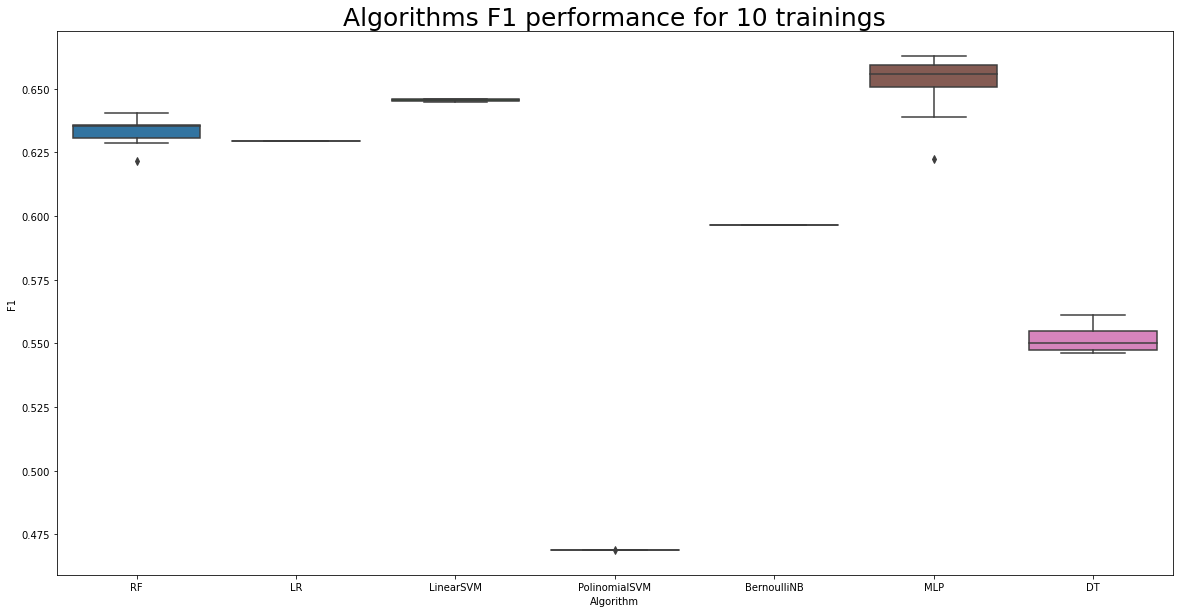

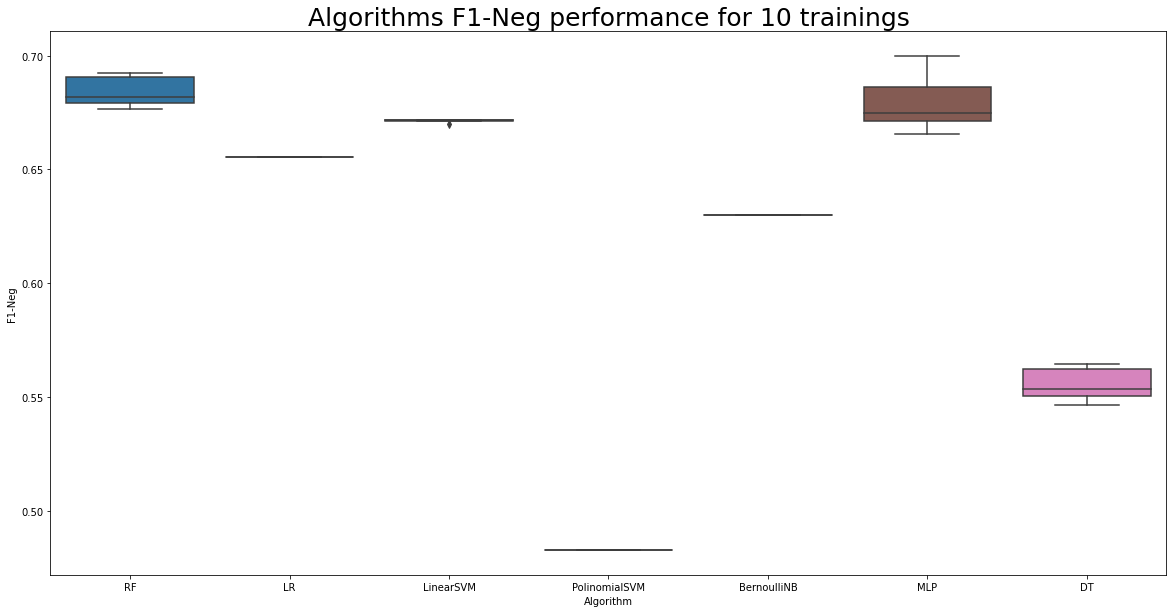

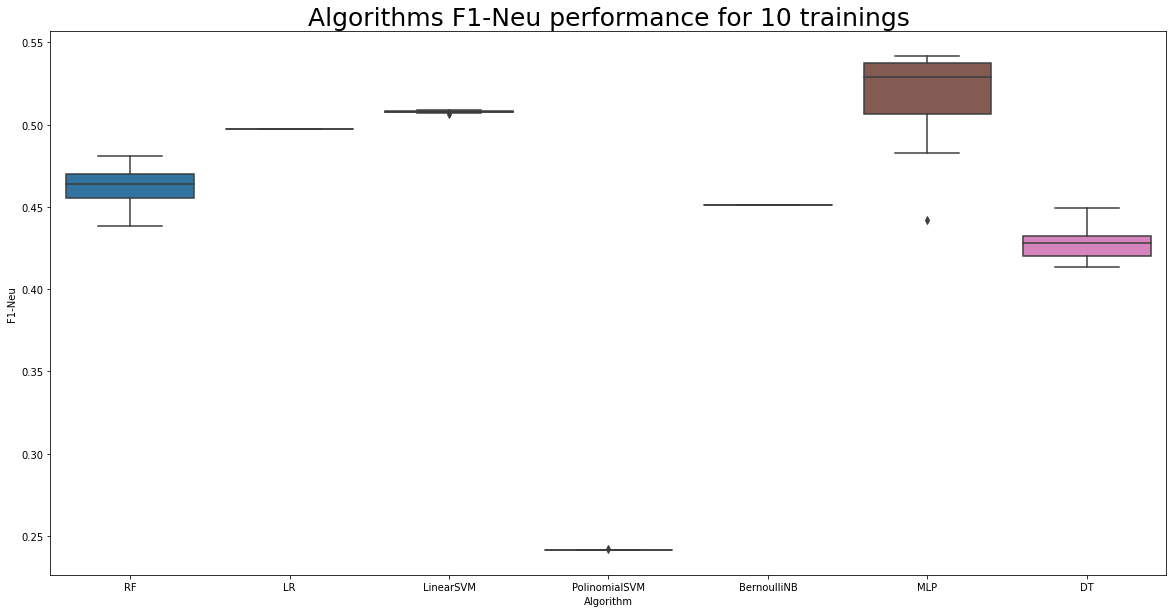

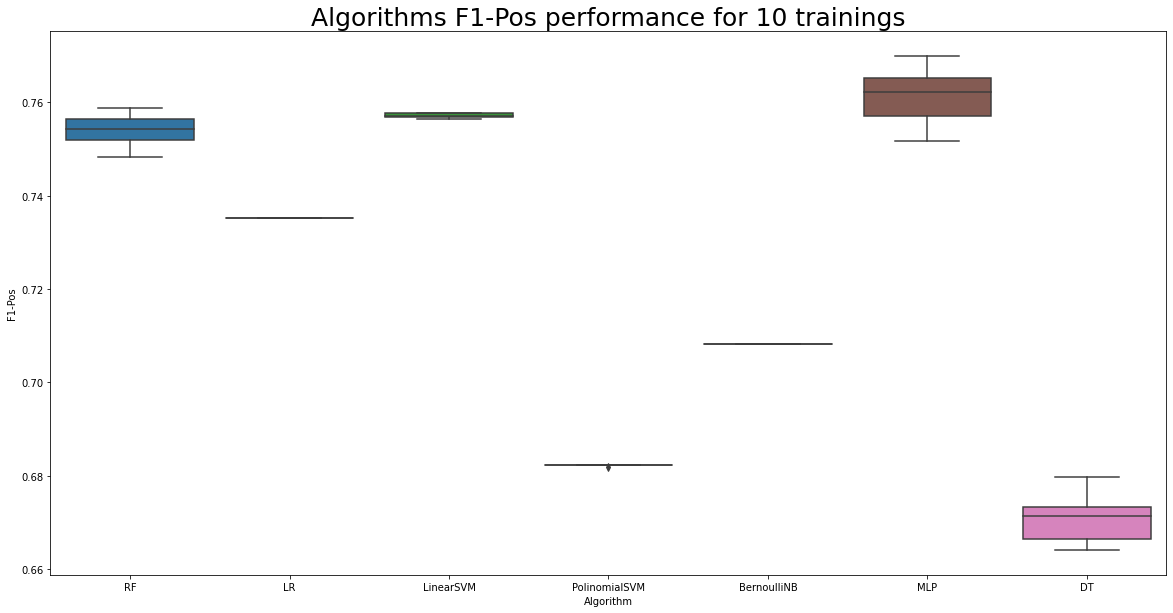

In [17]:
display(HTML('<h3>Individual Predictions</h3>'))
display(evaluation_frame.head(10))

display(HTML('<h3>Summarized Predictions</h3>'))
display(evaluation_summary_frame.sort_values(by=('F1', 'mean'), ascending=False))

for column in ['F1', 'F1-Neg', 'F1-Neu', 'F1-Pos']:
    plt.figure(figsize=(20,10))
    ax = sns.boxplot(x="Algorithm", y=column, data=evaluation_frame)
    ax.set_title(f'Algorithms {column} performance for {training_repetitions} trainings', fontdict={'fontsize':25});